# Find optimal colour fit 

Runs scipy optimise on source_synphot to get the coefficients that scale PS1 filters to get lowest colour residuals from the CK spectral library. 

In [1]:
import sys
sys.path
sys.path.append('../../../source_synphot/')
import source_synphot.passband
import source_synphot.io
import source_synphot.source
import astropy.table as at
from collections import OrderedDict
import pysynphot as S
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
%matplotlib notebook

#from zp_fit import *
from scipy.optimize import minimize
from astropy.stats import sigma_clip
import pandas as pd
import warnings
#warnings.filterwarnings("ignore")
def myround(x, prec=2, base=.5):
    return round(base * round(float(x)/base),prec)

In [2]:
models = at.Table.read('../../../source_synphot/ckmodels.txt',format='ascii')
logZ = 0.
model_sed_names = []
temp = []
for s in models:
    teff = max(3500.,s['teff'])
    logg = myround(s['logg'])
    # the models with logg < 1 are just padded with 0s
    if logg >= 1:
        temp.append(teff)
        modstring = 'ckmod{:.0f}_{:.1f}_{:.2f}'.format(teff,logZ, logg)
        model_sed_names.append(modstring)
model_sed = source_synphot.source.load_source(model_sed_names)

../../../source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod44852_0.0_4.00 not loaded
  warnings.warn(message, RuntimeWarning)
../../../source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod42857_0.0_4.00 not loaded
  warnings.warn(message, RuntimeWarning)
../../../source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod40862_0.0_4.00 not loaded
  warnings.warn(message, RuntimeWarning)
../../../source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod39865_0.0_4.00 not loaded
  warnings.warn(message, RuntimeWarning)
../../../source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod40300_0.0_3.50 not loaded
  warnings.warn(message, RuntimeWarning)
../../../source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod39000_0.0_3.00 not loaded
  warnings.warn(message, RuntimeWarning)
../../../source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod34200_0.0_3.00 not loaded
  war

In [3]:
passbands = at.Table.read('../../../source_synphot/source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("TESS")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

In [4]:
pbt, zpt = pbs['tess']

In [5]:
pbs

OrderedDict([('tess',
              (<pysynphot.spectrum.ArraySpectralElement at 0x13260b2e10>,
               -21.8904558292275)),
             ('tessps1',
              (<pysynphot.spectrum.ArraySpectralElement at 0x13261213c8>,
               -21.88238391456467)),
             ('ps1g',
              (<pysynphot.spectrum.ArraySpectralElement at 0x1326089470>,
               -20.836195000114955)),
             ('ps1r',
              (<pysynphot.spectrum.ArraySpectralElement at 0x13260b2ba8>,
               -21.370261319386927)),
             ('ps1i',
              (<pysynphot.spectrum.ArraySpectralElement at 0x1326126860>,
               -21.793287528964058)),
             ('ps1z',
              (<pysynphot.spectrum.ArraySpectralElement at 0x13260b2710>,
               -22.09903034378283)),
             ('ps1y',
              (<pysynphot.spectrum.ArraySpectralElement at 0x1325eb05c0>,
               -22.325516493196154))])

In [6]:
color1 = 'ps1g_ps1r'
color2 = 'tessps1_tess'
color3 = 'ps1g_tess'
color4 = 'tess_ps1i'
color5 = 'tess_ps1z'
col1 = []
col2 = []
col3 = []
col4 = []
col5 = []
col6 = []
# construct color-color vectors
i = 'ps1i'
z = 'ps1z'
t = 'tess'
tp = 'tessps1'
for modelname in model_sed:
    model= model_sed[modelname]
    model = S.ArraySpectrum(model.wave, model.flux, name=modelname)
    g, r = color1.split('_')
    pbg, zpg = pbs[g]
    pbr, zpr = pbs[r]

    pbi, zpi = pbs[i]
    pbz, zpz = pbs[z]
    pbt, zpt = pbs[t]
    pbtp, zptp = pbs[tp]
    thiscol1 = source_synphot.passband.syncolor(model, pbg, pbr, zpg, zpr)
    thiscol2 = source_synphot.passband.syncolor(model, pbtp, pbt, zptp, zpt)
    thiscol3 = source_synphot.passband.syncolor(model, pbr, pbt, zpr, zpt)
    thiscol4 = source_synphot.passband.syncolor(model, pbt, pbi, zpt, zpi)
    thiscol5 = source_synphot.passband.syncolor(model, pbt, pbz, zpt, zpz)
    #thiscol6 = source_synphot.passband.syncolor(model, pbi, pbz, zpi, zpz)

    col1.append(thiscol1)
    col2.append(thiscol2)
    col3.append(thiscol3)
    col4.append(thiscol4)
    col5.append(thiscol5)
    #col6.append(thiscol6)
col1 = np.array(col1)
col2 = np.array(col2)
col3 = np.array(col3)
col4 = np.array(col4)
col5 = np.array(col5)
#col6 = np.array(col6)
# select only useful objects
good = ~np.isnan(col1)* ~np.isnan(col2)* ~np.isnan(col3)* ~np.isnan(col4)* ~np.isnan(col5)#* ~np.isnan(col6)
good = np.array(good)

-43.46142641608394 -42.98333592355688
-42.591343477055524 -42.59288150844757
-42.98333592355688 -42.59288150844757
-42.59288150844757 -42.60947897282194
-42.59288150844757 -42.30620538941916
-43.42811488150393 -42.951515875740036
-42.559907880443674 -42.56134065631042
-42.951515875740036 -42.56134065631042
-42.56134065631042 -42.57774416616112
-42.56134065631042 -42.27580812278789
-43.39254864242051 -42.91768135862316
-42.526207497548135 -42.52748194878339
-42.91768135862316 -42.52748194878339
-42.52748194878339 -42.543554018019584
-42.52748194878339 -42.24330276234709
-43.353785389445065 -42.880558352350945
-42.48876265547233 -42.48982132892896
-42.880558352350945 -42.48982132892896
-42.48982132892896 -42.505428421999966
-42.48982132892896 -42.206909080304385
-43.31022613671858 -42.83852207668186
-42.44600530751533 -42.44677360678013
-42.83852207668186 -42.44677360678013
-42.44677360678013 -42.46180740425197
-42.44677360678013 -42.16510897892403
-43.26048351414385 -42.79024698323816
-

-37.996950882345445 -38.437722033438334
-38.55326277989199 -38.553989060739994
-38.437722033438334 -38.553989060739994
-38.553989060739994 -38.56523842312828
-38.553989060739994 -38.590614338389074
-37.041836871944284 -37.75362225063052
-37.97949954029809 -37.98257163161324
-37.75362225063052 -37.98257163161324
-37.98257163161324 -37.98193650475916
-37.98257163161324 -38.070770137237176
-36.30623009893371 -37.187886170716304
-37.51019887594573 -37.51475865230017
-37.187886170716304 -37.51475865230017
-37.51475865230017 -37.49589104696214
-37.51475865230017 -37.64850688626433


<IPython.core.display.Javascript object>


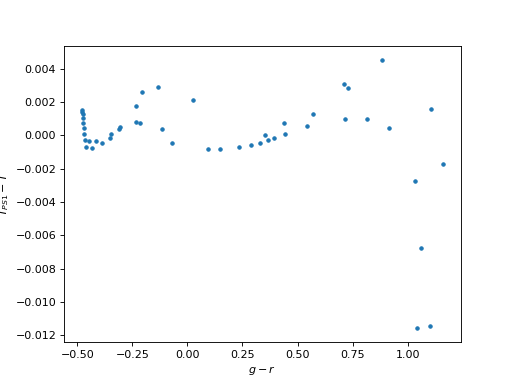

In [20]:
plt.figure()
plt.plot(col1,col2,'.')
plt.ylabel('$T_{PS1} - T$')
plt.xlabel('$g-r$')
plt.savefig('colour_residuals.pdf')

<IPython.core.display.Javascript object>


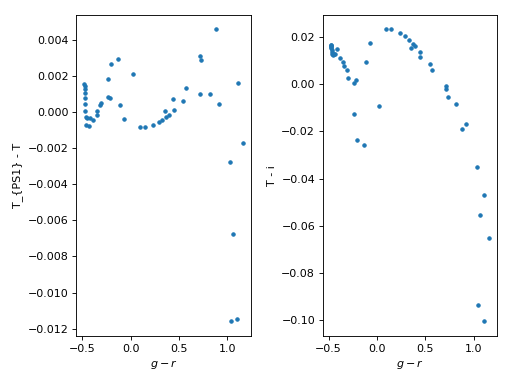

In [11]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(col1,col2,'.')
plt.ylabel('T_{PS1} - T')
plt.xlabel('$g-r$')
plt.subplot(1,2,2)
plt.plot(col1,col4,'.')
plt.ylabel('T - i')
plt.xlabel('$g-r$')
plt.tight_layout()

In [23]:
import numpy as np

from scipy import interpolate

In [24]:
TESS = np.loadtxt('../../filters/TESS/TESS.dat')
Kepler = np.loadtxt('../../filters/Kepler/Kepler.dat')
PSg = np.loadtxt('../../filters/PANSTARRS/PAN-STARRS_PS1_g.dat')
PSr = np.loadtxt('../../filters/PANSTARRS/PAN-STARRS_PS1_r.dat')
PSi = np.loadtxt('../../filters/PANSTARRS/PAN-STARRS_PS1_i.dat')
PSz = np.loadtxt('../../filters/PANSTARRS/PAN-STARRS_PS1_z.dat')
PSy = np.loadtxt('../../filters/PANSTARRS/PAN-STARRS_PS1_y.dat')
def Norm(filt):
    f = filt.copy()
    f[:,1] = f[:,1] / np.nanmax(f[:,1])#
    #f[:,1] = f[:,1] / np.trapz(f[:,1],x=f[:,0])
    return f

In [25]:
x = np.arange(np.nanmin(PSr[:,0]),np.max(TESS[:,0]))
psr = interpolate.interp1d(Norm(PSr)[:,0],Norm(PSr)[:,1],bounds_error=False,fill_value=0)
psi = interpolate.interp1d(Norm(PSi)[:,0],Norm(PSi)[:,1],bounds_error=False,fill_value=0)
psz = interpolate.interp1d(Norm(PSz)[:,0],Norm(PSz)[:,1],bounds_error=False,fill_value=0)
psy = interpolate.interp1d(Norm(PSy)[:,0],Norm(PSy)[:,1],bounds_error=False,fill_value=0)
ps1 = np.array([psr(x),psi(x),psz(x),psy(x)])
tess = interpolate.interp1d(Norm(TESS)[:,0],Norm(TESS)[:,1],bounds_error=False,fill_value=0)
r = np.nansum( psr(x) * tess(x)) / np.nansum(psr(x))
i = np.nansum( psi(x) * tess(x)) / np.nansum(psi(x))
z = np.nansum( psz(x) * tess(x)) / np.nansum(psz(x))
y = np.nansum( psy(x) * tess(x)) / np.nansum(psy(x))

In [67]:
def Fit_filts(coeffs,wave,ps1):
    fake = np.nansum(coeffs[:,np.newaxis]*ps1,axis=0)
    filt = np.array([wave,fake]).T
    np.savetxt('../../../source_synphot/source_synphot/passbands/TESS/ps1_tess.dat',filt)
    
    passbands = at.Table.read('../../../source_synphot/source_synphot/passbands/pbzptmag.txt',format='ascii')
    pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("TESS")]
    pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
    model_mags = 0.
    model = 'AB'
    pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
    pbnames = pbs.keys()
    g = 'ps1g'
    r = 'ps1r'
    t = 'tess'
    tp = 'tessps1'
    col1 = []
    col2 = []
    for modelname in model_sed:
        model= model_sed[modelname]
        model = S.ArraySpectrum(model.wave, model.flux, name=modelname)
        pbg, zpg = pbs[g]
        pbr, zpr = pbs[r]
        pbt, zpt = pbs[t]
        pbtp, zptp = pbs[tp]
        thiscol1 = source_synphot.passband.syncolor(model, pbg, pbr, zpg, zpr)
        thiscol2 = source_synphot.passband.syncolor(model, pbtp, pbt, zptp, zpt)
        col1.append(thiscol1)
        col2.append(thiscol2)
    col1 = np.array(col1)
    col2 = np.array(col2)

    # select only useful objects
    good = ~np.isnan(col1)* ~np.isnan(col2)
    good = np.array(good)
    xx = np.arange(np.nanmin(col1[good]),np.nanmax(col1[good]),0.01)
    fun = interpolate.interp1d(col1[good],col2[good])
    res = np.trapz(np.abs(fun(xx)),x=xx)
    print(res)
    return res

In [68]:
from scipy.optimize import minimize
coeff = np.array([r,i,z,y])
res = minimize(Fit_filts,coeff,args=(x,ps1))

0.045616428112875786
0.0456164303271247
0.04561642792685544
0.045616427267119036
0.045616427383693495
0.045616428112875786
0.016626616403723066
0.016626616403723066
0.016626618907089503
0.016626616366260956
0.016626615640391078
0.016626615716687
0.12929069617497418
0.12929069617497418
0.12929069188831754
0.12929069521973907
0.12929069642054924
0.12929069660805648
0.004904170155494268
0.004904170155494268
0.004904168508083427
0.004904170004879543
0.004904170631041286
0.004904170614046041
0.017247638290300384
0.017247638290300384
0.01724764076976261
0.01724763824970733
0.017247637530537607
0.017247637607197986
0.003196546574594332
0.003196546574594332
0.003196546332827157
0.003196546467993524
0.0031965466903423247
0.0031965466959048665
0.0031493808110338636
0.0031493808110338636
0.003149381203192233
0.0031493807152212453
0.0031493807584753847
0.0031493807788172843
0.003056135334010792
0.003056135334010792
0.003056135648799625
0.0030561352407598268
0.003056135301125773
0.00305613531872083

0.002459867983199036
0.002459867983254176
0.0024599263488193695
0.0024599263488193695
0.002459926336308663
0.002459926346161832
0.0024599263526850035
0.002459926354742591
0.0024598751425537473
0.0024598751425537473
0.0024598750597668593
0.002459875138344258
0.0024598751653986855
0.002459875165452779
0.0024598688460134863
0.0024598688460134863
0.0024598687632271434
0.0024598688418057003
0.00245986886885951
0.0024598688689153676
0.0024598680696354663
0.0024598680696354663
0.0024598679868508364
0.0024598680654291027
0.002459868092483825
0.002459868092535777
0.002459867973822915
0.002459867973822915
0.0024598679021249448
0.0024598679696144704
0.002459867996668164
0.002459867996722056
0.002459867961544277
0.002459867961544277
0.0024598678929141815
0.002459867957336264
0.0024598679843911256
0.002459867984444657
0.0024598679604510595
0.0024598679604510595
0.0024598678920948872
0.002459867956241408
0.002459867983297544
0.002459867983351175
0.002459867960360334
0.002459867960360334
0.0024598678

0.002459867892021979
0.0024598679561440963
0.002459867983199036
0.002459867983254525
0.0024598679603527523
0.0024598679603527523
0.002459867892021979
0.0024598679561440963
0.002459867983199107
0.002459867983254525
0.0024599263488193695
0.0024598809624093642
0.002459870870235264
0.002459868611600385
0.0024598681061069453
0.002459867992972608
0.0024598679676553323
0.0024598679619878055
0.0024598679607180938
0.0024598679604358993
0.0024598679603713963
0.002459867960357411


In [86]:
res.x

array([0.41656058, 1.12264514, 0.95252585, 0.76186266])

In [79]:
first = np.nansum(coeff[:,np.newaxis]*ps1,axis=0)
fake = np.nansum(res.x[:,np.newaxis]*ps1,axis=0)

In [27]:
coeffs = np.array([0.41656058, 1.12264514, 0.95252585, 0.76186266])
fake = np.nansum(coeffs[:,np.newaxis]*ps1,axis=0)

In [28]:
fake.shape

(5980,)

<IPython.core.display.Javascript object>


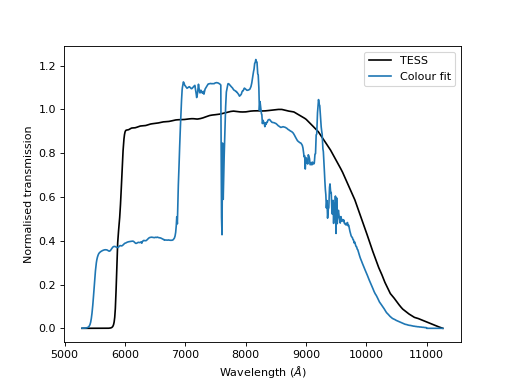

In [32]:
plt.figure()
plt.plot(x,tess(x),'k',label='TESS')
#plt.plot(first,label='Convolution')
plt.plot(x,fake,label='Colour fit')
plt.legend()
plt.ylabel('Normalised transmission')
plt.xlabel('Wavelength ($\AA$)')
plt.savefig('colour_fit.pdf')

In [87]:
res.x

array([0.41656058, 1.12264514, 0.95252585, 0.76186266])

In [13]:
np.savetxt('TESS_ps1_coeffs.dat',np.array([0.41656058, 1.12264514, 0.95252585, 0.76186266]).T)

In [14]:
import pandas as pd

In [16]:
pd.read_csv('TESS_ps1_coeffs.dat')

,r,i,z,y
0,0.416561,1.122645,0.952526,0.761863
